In [22]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

from utils import getLabelIdx, hyperparameters, getAccuracy, show
from BirdDataset import BirdDataset
from model import ClassifierModel

import matplotlib.pyplot as plt
%matplotlib inline
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generating indices for labels

Labels are given as names. Get indices for the same

In [23]:
label_idx = getLabelIdx('data/BIRDS-150.txt')
print(json.dumps(label_idx, indent = 2))

{
  "ALBATROSS": 0,
  "ALEXANDRINE PARAKEET": 1,
  "AMERICAN AVOCET": 2,
  "AMERICAN BITTERN": 3,
  "AMERICAN COOT": 4,
  "AMERICAN GOLDFINCH": 5,
  "AMERICAN KESTREL": 6,
  "AMERICAN REDSTART": 7,
  "ANHINGA": 8,
  "ANNAS HUMMINGBIRD": 9,
  "BALD EAGLE": 10,
  "BALTIMORE ORIOLE": 11,
  "BANANAQUIT": 12,
  "BAR-TAILED GODWIT": 13,
  "BARN OWL": 14,
  "BARN SWALLOW": 15,
  "BAY-BREASTED WARBLER": 16,
  "BELTED KINGFISHER": 17,
  "BIRD OF PARADISE": 18,
  "BLACK FRANCOLIN": 19,
  "BLACK SKIMMER": 20,
  "BLACK SWAN": 21,
  "BLACK THROATED WARBLER": 22,
  "BLACK-CAPPED CHICKADEE": 23,
  "BLACK-NECKED GREBE": 24,
  "BLACKBURNIAM WARBLER": 25,
  "BLUE HERON": 26,
  "BOBOLINK": 27,
  "BROWN THRASHER": 28,
  "CACTUS WREN": 29,
  "CALIFORNIA CONDOR": 30,
  "CALIFORNIA GULL": 31,
  "CALIFORNIA QUAIL": 32,
  "CAPE MAY WARBLER": 33,
  "CASSOWARY": 34,
  "CHARA DE COLLAR": 35,
  "CHIPPING SPARROW": 36,
  "CINNAMON TEAL": 37,
  "COCK OF THE  ROCK": 38,
  "COCKATOO": 39,
  "COMMON GRACKLE": 40,
  "CO

## Dataset

Loading the dataset in the class we made. The class will help for loading batches.

In [24]:
train_transforms = transforms.Compose([transforms.ToTensor()])

train_set = BirdDataset('data/train/', label_idx, transform = train_transforms)
val_set = BirdDataset('data/valid/', label_idx, transform = train_transforms)

print("Loaded {} training samples".format(len(train_set)))
print("Loaded {} validation samples".format(len(val_set)))

Loaded 19774 training samples
Loaded 750 validation samples


Getting a look on the images

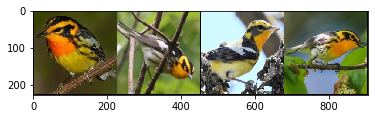

In [25]:
num_display = 4
to_display_images = []
for i in range(num_display):
    to_display_images.append(train_set[i]['image'])

show(make_grid(to_display_images, nrow = 4))

Finally, making a data loader

In [26]:
train_loader = DataLoader(train_set,
                          batch_size=hyperparameters['train-batch-size'],
                          shuffle=True,
                          num_workers=6)

val_loader = DataLoader(val_set,
                        batch_size=32,
                        shuffle=True,
                        num_workers=6)

## Training set up

We will set up the model, optimizer and loss function. In addition, a scheduler is created which will decrease the learning rate by factor of 0.1 when loss is not improving for 3 epochs.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ClassifierModel()
net.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr = hyperparameters['lr'],
                      momentum = hyperparameters['momentum'],
                      weight_decay=hyperparameters['weight-decay'])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.1,
                                                 patience=3)

Summary of the model

In [28]:
summary(net, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
         MaxPool2d-2         [-1, 64, 112, 112]               0
            Conv2d-3        [-1, 128, 112, 112]          73,856
         MaxPool2d-4          [-1, 128, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]         295,168
            Conv2d-6          [-1, 256, 56, 56]         590,080
         MaxPool2d-7          [-1, 256, 28, 28]               0
            Conv2d-8          [-1, 512, 28, 28]       1,180,160
            Conv2d-9          [-1, 512, 28, 28]       2,359,808
        MaxPool2d-10          [-1, 512, 14, 14]               0
           Conv2d-11          [-1, 512, 14, 14]       2,359,808
           Conv2d-12          [-1, 512, 14, 14]       2,359,808
        MaxPool2d-13            [-1, 512, 7, 7]               0
           Linear-14                 [-

For logging training statistics

In [29]:
writer = SummaryWriter()

train_stats = {
    'running-train-loss': 0.0,
    'running-val-loss': 0.0,
    'running-train-acc': 0.0,
    'running-val-acc': 0.0,
    'train-loss-epochs': [],
    'train-acc-epochs': [],
    'val-loss-epochs': [],
    'val-acc-epochs': []
}

## Training!

In [30]:
print("Training across {} batches, validating on {} batches".format(len(train_loader), len(val_loader)))

for epoch in range(hyperparameters['epochs']):
    train_stats['running-train-loss'] = 0.0
    train_stats['running-train-acc'] = 0.0
    
    all_samples = 0
    correct = 0
    
    net.train()
    for i, batch in enumerate(train_loader):
        inputs, labels = batch['image'], batch['label']
        labels = torch.LongTensor(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        net_outputs = net(inputs)
        loss = loss_func(net_outputs, labels)
        loss.backward()
        optimizer.step()
        
        correct += getAccuracy(net_outputs, labels)
        all_samples += net_outputs.shape[0]
        
        train_stats['running-train-loss'] += loss.item()
    train_stats['running-train-acc'] = correct*1.0/all_samples
    
    # Validation
    train_stats['running-val-loss'] = 0.0
    net.eval()
    all_samples = 0
    correct = 0
    for _, batch in enumerate(val_loader):
        inputs, labels = batch['image'], batch['label']
        labels = torch.LongTensor(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        net_outputs = net(inputs)
        
        correct += getAccuracy(net_outputs, labels)
        val_loss = loss_func(net_outputs, labels)
        train_stats['running-val-loss'] += val_loss.item()
        all_samples += net_outputs.shape[0]
        
        train_stats['running-val-loss'] += loss.item()
    train_stats['running-val-acc'] = correct*1.0/all_samples
    
    # Decreasing the learning rate
    if scheduler:
        scheduler.step(train_states['running-val-acc'])
    
    # logging statistics
    print("Epoch {} --> Training loss: {.3f}\tTraining acc: {.3f}\tValidation loss: {.3f}\tValidation acc:{.3f}"
          .format(epoch + 1,
                  train_stats['running-train-loss'],
                  train_stats['running-train-acc'],
                  train_stats['running-val-loss'],
                  train_stats['running-val-acc']))
    writer.add_scalar("Loss/train", train_stats['running-train-loss'], epoch + 1)
    writer.add_scalar("Loss/validation", train_stats['running-val-loss'], epoch + 1)
    writer.add_scalar("Accuracy/train", train_stats['running-train-acc'], epoch + 1)
    writer.add_scalar("Accuracy/validation", train_stats['running-val-ac'], epoch + 1)
    
    train_stats['train-loss-epochs'].append(train_stats['running-train-loss'])
    train_stats['val-loss-epochs'].append(train_stats['running-val-loss'])
    train_stats['train-acc-epochs'].append(train_stats['running-train-acc'])
    train_stats['val-acc-epochs'].append(train_stats['running-val-acc'])

writer.close()

Training across 4944 batches, validating on 24 batches


KeyboardInterrupt: 

## Training progress

In [ ]:
fig, (loss_graph, acc_graph) = plt.subplots(1, 2)
loss_graph.plot(train_stats['running-train-loss'], color = 'red', label = 'Training')
loss_graph.plot(train_stats['running-val-loss'], color = 'blue', label = 'Validation')
loss_graph.set_title("Loss")
loss_graph.legend()

acc_graph.plot(train_stats['running-train-acc'], color = 'red', label = 'Training')
acc_graph.plot(train_stats['running-train-acc'], color = 'blue', label = 'Validation')
acc_graph.set_title("Accuracy")
acc_graph.legend()

plt.show()